/home/philipslinux/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/philipslinux/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Train Loss: 0.6014, Train Accuracy: 71.31%, Valid Loss: 0.4218, Valid Accuracy: 82.03%
Best model saved with validation accuracy: 82.03%
Epoch [2/30], Train Loss: 0.4303, Train Accuracy: 84.43%, Valid Loss: 0.3098, Valid Accuracy: 87.50%
Best model saved with validation accuracy: 87.50%
Epoch [3/30], Train Loss: 0.3207, Train Accuracy: 91.23%, Valid Loss: 0.4186, Valid Accuracy: 87.50%
Epoch [4/30], Train Loss: 0.2605, Train Accuracy: 94.66%, Valid Loss: 0.4112, Valid Accuracy: 86.20%
Epoch [5/30], Train Loss: 0.1762, Train Accuracy: 98.35%, Valid Loss: 0.5634, Valid Accuracy: 87.24%
Epoch [6/30], Train Loss: 0.2019, Train Accuracy: 97.23%, Valid Loss: 0.4531, Valid Accuracy: 87.24%
Epoch [7/30], Train Loss: 0.1712, Train Accuracy: 98.68%, Valid Loss: 0.5772, Valid Accuracy: 89.84%
Best model saved with validation accuracy: 89.84%
Epoch [8/30], Train Loss: 0.1413, Train Accuracy: 100.00%, Valid Loss: 0.6823, Valid Accuracy: 88.54%
Epoch [9/30], Train Loss: 0.1377, Train A

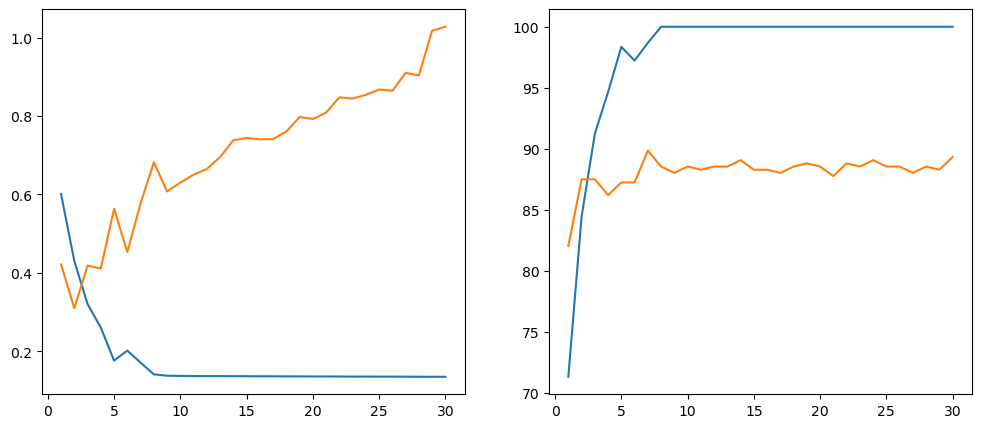

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models, datasets
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Parameters
train_ratio = 0.7
batch_size = 4
lr = 0.00001
num_epochs = 30
best_model_path = "./checkpoints/best_model_res152_dif.pth"
a, b, c = 0.2, 0.3, 0.5
loss_weight_main, loss_weight_aux = 0.7, 0.3

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Light adjustment of brightness, contrast, etc.
#     transforms.RandomHorizontalFlip(p=0.3),  # Flip the image horizontally with a low probability
#     transforms.RandomRotation(degrees=5),  # Slight random rotation (±5 degrees)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with standard ImageNet stats
])

# Load dataset
train_set = datasets.ImageFolder(root="./syn_vision_dataset/train", transform=transform)

# Split into training and validation sets
total_samples = len(train_set)
train_samples = int(train_ratio * total_samples)
val_samples = total_samples - train_samples
train_data, valid_data = torch.utils.data.random_split(train_set, [train_samples, val_samples])

# Extract labels for training data
train_labels = [train_set.targets[idx] for idx in train_data.indices]

# Apply Random Over Sampling
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
train_indices, train_labels = ros.fit_resample(np.array(train_data.indices).reshape(-1, 1), train_labels)
train_indices = train_indices.flatten()

# Create a new training dataset with oversampled indices
oversampled_train_data = torch.utils.data.Subset(train_set, train_indices)

# DataLoaders
train_loader = DataLoader(oversampled_train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False)

# Test dataset
test_dataset = datasets.ImageFolder(root="./syn_vision_dataset/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Diffusion Network class
class DiffusionNetwork(nn.Module):
    def __init__(self, num_classes=2):
        super(DiffusionNetwork, self).__init__()
        self.backbone1 = models.resnet152(pretrained=True)
        self.feature_extractor1 = nn.Sequential(*list(self.backbone1.children())[:-2])
        self.feature_extractor2 = nn.Sequential(*list(self.backbone1.children())[:-50])    
        self.feature_extractor3 = nn.Sequential(*list(self.backbone1.children())[:-100])    
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.local_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(34816 , 256)
        self.fc2 = nn.Linear(51, 256)
        self.fc3 = nn.Linear(51, 256)
        self.fc_out1 = nn.Linear(256, num_classes)
        self.fc_out2 = nn.Linear(256, num_classes)
        self.fc_out3 = nn.Linear(256, num_classes)
        self.fc_out_final = nn.Linear(6, num_classes)
    
    def forward(self, x):
        features1 = self.feature_extractor1(x)
        global_features1 = self.global_pool(features1).view(x.size(0), -1)
        local_features1 = self.local_pool(features1).view(x.size(0), -1)
        combined_features1 = torch.cat((global_features1, local_features1), dim=1)

        features2 = self.feature_extractor2(x)
        global_features2 = self.global_pool(features2).view(x.size(0), -1)
        local_features2 = self.local_pool(features2).view(x.size(0), -1)
        combined_features2 = torch.cat((global_features2, local_features2), dim=1)

        features3 = self.feature_extractor3(x)
        global_features3 = self.global_pool(features3).view(x.size(0), -1)
        local_features3 = self.local_pool(features3).view(x.size(0), -1)
        combined_features3 = torch.cat((global_features3, local_features3), dim=1)

        out1 = self.fc_out1(self.fc1(combined_features1))
        out2 = self.fc_out2(self.fc2(combined_features2))
        out3 = self.fc_out3(self.fc3(combined_features3))
        out_cat = torch.cat((out1, out2, out3), dim=1)        
        final_out = self.fc_out_final(out_cat)
        
        return final_out, out1, out2, out3

# Training and evaluation functions
def train_one_epoch(model, optimizer, criterion_main, criterion_aux, train_loader, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, out1, out2, out3 = model(images)
        loss_main = criterion_main(outputs, labels)
        loss_aux = (
            criterion_aux(out1, labels) + \
            criterion_aux(out2, labels) + \
            criterion_aux(out3, labels)
        ) / 3
        loss = loss_weight_main * loss_main + loss_weight_aux * loss_aux
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    return avg_loss, accuracy

def evaluate(model, criterion_main, valid_loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs, _, _, _ = model(images)
            loss = criterion_main(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(valid_loader)
    accuracy = total_correct / total_samples * 100
    report = classification_report(all_labels, all_preds, target_names=train_set.classes, output_dict=True)
    return avg_loss, accuracy, report

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionNetwork(num_classes=2).to(device)
criterion_main = nn.CrossEntropyLoss()
criterion_aux = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

best_valid_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, optimizer, criterion_main, criterion_aux, train_loader, device)
    valid_loss, valid_acc, valid_report = evaluate(model, criterion_main, valid_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%")

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation accuracy: {valid_acc:.2f}%")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Val Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Val Acc')



In [2]:
# Load the best model from the checkpoint
model.load_state_dict(torch.load(best_model_path))
model.eval()
# Test the best model
test_loss, test_accuracy, test_report = evaluate(model, criterion_main, test_loader, device)
print("\nTest Results (using best model from checkpoint):")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%")
print("Test Classification Report:", test_report)

/tmp/ipykernel_318425/2774835702.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Test Results (using best model from checkpoint):
Test Loss: 0.3004, Test Accuracy: 93.1250%
Test Classification Report: {'bad': {'precision': 0.9466666666666667, 'recall': 0.9793103448275862, 'f1-score': 0.9627118644067797, 'support': 290}, 'good': {'precision': 0.7, 'recall': 0.4666666666666667, 'f1-score': 0.56, 'support': 30}, 'accuracy': 0.93125, 'macro avg': {'precision': 0.8233333333333333, 'recall': 0.7229885057471264, 'f1-score': 0.7613559322033898, 'support': 320}, 'weighted avg': {'precision': 0.9235416666666666, 'recall': 0.93125, 'f1-score': 0.9249576271186442, 'support': 320}}


In [3]:
!pip uninstall Qiskit

In [4]:
!